# Testing ML models using ACCESS data

This notebook loads in relevant input data (generated by `data_retrieval.ipynb`) and calculated MOC strength timeseries, and fits a number of machine learning models to the data. Evaluation metrics are given in each case. 

Results reproducable from this notebook are displayed in Tables **blah** and **blah** in our final report. These were calculated using the regularised linear regression and MLP sections respectively.

Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import xarray as xr
from plotting_utils import *
from train import *
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as mse

def custom_MAPE(y_test, y_pred, threshold = 0, return_num_discarded = False):

    """
    A custom mean absolute percentage error metric that ignores very small values.

    Parameters
    ----------
    y_test : numpy.array
        observed values on the test set (ground truth)
    y_pred : numpy.array
        predicted values for the test set
    threshold : float
        only keep observations that are more extreme than +/- threshold
    return_num_discarded : boolean
        should we return the number of samples that were discarded using
        this threshold?

    Returns
    -------
    mape, initial_len : float, integer
    OR
    mape : float
        the MAPE and, optionally, the number of samples discarded
    """

    # Get starting length of test set
    initial_len = len(y_test)

    # Mask out values less extreme than threshold
    mask = np.abs(y_test) > threshold
    y_test, y_pred = y_test[mask], y_pred[mask]
    new_len = len(y_test)

    # Calculate the MAPE on this subset of the test set - a small number is added
    #  to the denominator to avoid dividing by zero
    mape = np.mean(np.abs((y_pred - y_test)) / (np.abs(y_test) + 1e-4))

    if return_num_discarded:
        return mape, initial_len - new_len

    return mape

## Import data

In [2]:
# Select time range of data to import (longest possible range for overlap with ECCO data is 1992-2017)
time_slice = slice('1992-01-01', '2017-12-31')

# Load ACCESS input data and drop irrelevant variables
input_data_60S_so = xr.open_dataset(f"processed_data/input_data_60S_so.nc")
input_data_60S_so = input_data_60S_so.drop(['u', 'v', 'xu_ocean', 'temp_yflux_adv'])
input_data_60S_so = input_data_60S_so.sel(time=time_slice)

# Load ECCO data to use the Zonal Wind Stress as a predictor
ECCO_data_60S_so = xr.open_dataset(f"../ECCO/data/60S.nc")

# Load MOC data calculated from ACCESS variables
MOC_60S_so = xr.open_dataset(f"processed_data/MOC_60S_so.nc", engine='netcdf4')
MOC_60S_so = MOC_60S_so.sel(time=time_slice)

# Extract individual variables
OBP = input_data_60S_so.pbot_t
SSH = input_data_60S_so.sea_level
ZWS = ECCO_data_60S_so.ZWS[:, 1, :] # Zonal Wind Stress at 60S (does not share shape with other varaibles due to different data sources)
SST = input_data_60S_so.surface_pot_temp
SSS = input_data_60S_so.surface_salt

In [3]:
# Display the input variables to be used as predictors
input_data_60S_so

<xarray.Dataset>
Dimensions:           (xt_ocean: 3600, time: 312)
Coordinates:
  * xt_ocean          (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
    yt_ocean          float64 ...
  * time              (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-1...
    yu_ocean          float64 ...
    st_ocean          float64 ...
Data variables:
    sea_level         (time, xt_ocean) float32 ...
    surface_pot_temp  (time, xt_ocean) float32 ...
    surface_salt      (time, xt_ocean) float32 ...
    pbot_t            (time, xt_ocean) float32 ...

In [4]:
# Display the MOC data to be used as the target
MOC_60S_so.MOC

<xarray.DataArray 'MOC' (time: 312)>
[312 values with dtype=float64]
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16T12:00:00
    yu_ocean  float64 ...
    st_ocean  float64 ...
    sigma_2   float64 ...

## Preprocess data

Use the first cell to choose whether to deseasonalise or not, and to select the surface variables to include in the model. 

Options are `OBP, ZWS, SSH, SSS, SST`, with `ZWS` only being available as a `zon_avg` variable.

Select the threshold used for custom MAPE metric (useful for deseasonalised detrended data). Value used in report: `0.5*1e-6`.

In [54]:
detrend_deseasonalise = True
full_zonal = [OBP, SSH]
zon_avg = [ZWS]
mape_thresh = 0.5*1e6

Code for constructing the input array - no modifications necessary to reproduce figures from report.

In [55]:
from sklearn import model_selection
import pandas as pd
from utils import *

if detrend_deseasonalise:
    # Deseason and detrend the input and output data
    input_data_60S_so = apply_preprocessing(input_data_60S_so, mode='inputs')
    MOC_60S_so = apply_preprocessing(MOC_60S_so, mode='outputs')

# Extract individual variables
OBP = input_data_60S_so.pbot_t
SSH = input_data_60S_so.sea_level
ZWS = ECCO_data_60S_so.ZWS[:, 1, :] # Zonal Wind Stress at 60S (does not share shape with other varaibles due to different data sources)
SST = input_data_60S_so.surface_pot_temp
SSS = input_data_60S_so.surface_salt

# raise exception if ZWS is included in zon_avg
if any((ZWS == x).all() for x in full_zonal):
    raise ValueError("ZWS may only be included in `zon_avg`")

# construct the combined input data
combined = xr.concat(full_zonal, dim='xt_ocean')

if len(zon_avg) > 0:
    zeros = np.zeros((OBP.shape[0], len(full_zonal)*OBP.shape[1] + len(zon_avg)))
    zeros[:, :-len(zon_avg)] = combined
    for i, var in enumerate(zon_avg):
        if var.equals(ZWS):
            zeros[:, -len(zon_avg) + i] = var.mean('longitude')
        else:
            zeros[:, -len(zon_avg) + i] = var.mean('xt_ocean')

    zeros = xr.DataArray(zeros, dims=('time', 'xt_ocean'))
    combined = zeros

x = combined
y = MOC_60S_so.MOC

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=42, shuffle=False)

x_test = x_test.sortby('time')
y_test = y_test.sortby('time')

# Linear regression (non-regularised)

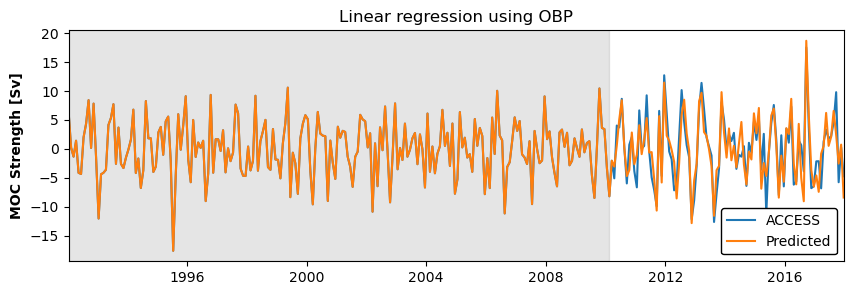

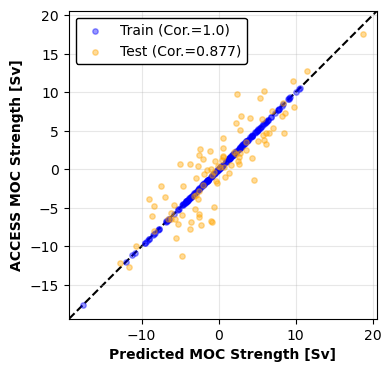

r [[1.         0.87698755]
 [0.87698755 1.        ]]
RMSE 2.792832261580264
MAE <xarray.DataArray 'MOC' ()>
array(2.18491786)
Coordinates:
    yu_ocean  float64 -60.02
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
MAPE 118.87588717145121
CMAPE <xarray.DataArray 'MOC' ()>
array(86.72650267)
Coordinates:
    yu_ocean  float64 -60.02
    st_ocean  float64 2.007e+03
    sigma_2   float64 2.007e+03
R2 0.7396484675622645


In [25]:
from sklearn import linear_model

mape_thresh = 0.5*1e6

linreg = linear_model.LinearRegression()

linreg.fit(x_train, y_train)

timeseries_comparison(linreg.predict(x)*1e-6, y*1e-6, x.time, len(x_train.time), 'ACCESS')
plt.title('Linear regression using OBP')
plt.show()

pred_vs_actual(linreg.predict(x_train)*1e-6, linreg.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')
plt.show()

print('r', np.corrcoef(linreg.predict(x_test), y_test))
print('RMSE', np.sqrt(mse(linreg.predict(x_test), y_test))*1e-6)
print('MAE', np.mean(np.abs(linreg.predict(x_test) - y_test))*1e-6)
print('MAPE', metrics.mean_absolute_percentage_error(linreg.predict(x_test), y_test)*100)
print('CMAPE', custom_MAPE(y_test, linreg.predict(x_test), threshold=mape_thresh)*100)
print('R2', metrics.r2_score(linreg.predict(x_test), y_test))



# Regularised linear regression using ElasticNet

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

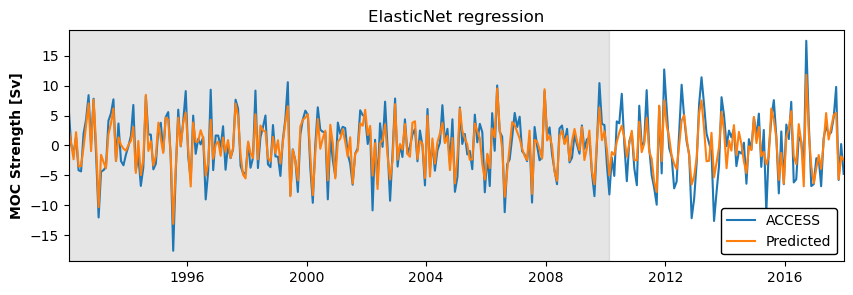

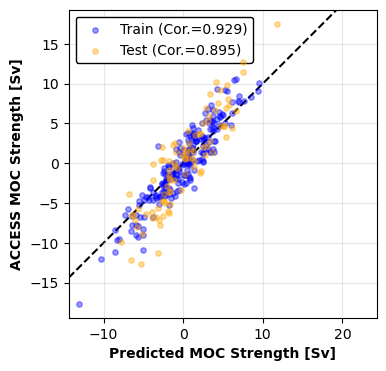

r 0.8950675297653763
RMSE 2.8769383308408822
MAE 2.3136315886278376
MAPE 166.922368753288
CMAPE 60.43517621603818
R2 0.4332622735507039


In [26]:
from sklearn.linear_model import ElasticNetCV



Enet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=0, max_iter=10000, n_jobs=-1, verbose=1, selection='random')
Enet.fit(x_train, y_train)

timeseries_comparison(Enet.predict(x)*1e-6, y*1e-6, x.time, len(x_train.time), 'ACCESS')
plt.title('ElasticNet regression')
plt.show()

pred_vs_actual(Enet.predict(x_train)*1e-6, Enet.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')
plt.show()

print('r', np.corrcoef(Enet.predict(x_test), y_test)[0][1])
print('RMSE', np.sqrt(mse(Enet.predict(x_test), y_test))*1e-6)
print('MAE', float(np.mean(np.abs(Enet.predict(x_test) - y_test))*1e-6))
print('MAPE', metrics.mean_absolute_percentage_error(Enet.predict(x_test), y_test)*100)
print('CMAPE', float(custom_MAPE(y_test, Enet.predict(x_test), threshold=mape_thresh)*100))
print('R2', metrics.r2_score(Enet.predict(x_test), y_test))

# Multi-layer Perceptrons

In [56]:
from MLP import *
import torch
import torch.nn.functional as F

# set the proportion of the training set to use as a validation set
val_ratio = 0.05

x_tensor = torch.from_numpy(x.to_numpy()).to(torch.float32)
y_tensor = torch.from_numpy(y.to_numpy()).to(torch.float32)

print(x_tensor.shape, y_tensor.shape)

x_validate = x_train[int(len(x_train)*(1-val_ratio)):, :]
y_validate = y_train[int(len(y_train)*(1-val_ratio)):]

x_validate_tensor = torch.from_numpy(x_validate.to_numpy()).to(torch.float32)
y_validate_tensor = torch.from_numpy(y_validate.to_numpy()).to(torch.float32)

print(x_validate_tensor.shape, y_validate_tensor.shape)

x_train_tensor = torch.from_numpy(x_train[:int(len(x_train)*(1-val_ratio)), :].to_numpy()).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train[:int(len(y_train)*(1-val_ratio))].to_numpy()).to(torch.float32)

print(x_train_tensor.shape, y_train_tensor.shape)

x_test_tensor = torch.from_numpy(x_test.to_numpy()).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test.to_numpy()).to(torch.float32)

torch.Size([312, 7201]) torch.Size([312])
torch.Size([11, 7201]) torch.Size([11])
torch.Size([207, 7201]) torch.Size([207])


Define ranges of MLP hyperparameters to be tested by grid search.

In [57]:
min_layer_num, max_layer_num = 1, 5
min_hidden_units, max_hidden_units = 1, 5
min_dropout, max_dropout, n_dropout = 0, 0, 1
min_lr, max_lr, n_lr = 0.05, 0.05, 1

Train MLP Models

In [58]:
count = 0
fin = (max_layer_num-min_layer_num+1)*(max_hidden_units-min_hidden_units+1)*n_dropout*n_lr
for n_layers in range(min_layer_num, max_layer_num+1):
    for n_hidden in range(min_hidden_units, max_hidden_units+1):
        for dropout in np.linspace(min_dropout, max_dropout, n_dropout):
            for lr in np.linspace(min_lr, max_lr, n_lr):
                print(f'\n\nRunning MLP with {n_layers} layers, {n_hidden} hidden units, dropout {dropout} and lr {lr}')
                mlp = MLP(x_train_tensor.shape[1], n_layers, n_hidden, dropout)
                train_model(mlp, x_train_tensor, y_train_tensor, f'MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP', early_stopping=True, lr=lr, X_val=x_validate_tensor, y_val=y_validate_tensor, max_iters=10000)
                count += 1
                print(f'{count}/{fin} completed')



Running MLP with 1 layers, 1 hidden units, dropout 0.0 and lr 0.05
device: cpu
7204 parameters.


100%|██████████| 10000/10000 [00:11<00:00, 859.25it/s]


1/25 completed


Running MLP with 1 layers, 2 hidden units, dropout 0.0 and lr 0.05
device: cpu
14407 parameters.


100%|██████████| 10000/10000 [00:14<00:00, 702.23it/s]


2/25 completed


Running MLP with 1 layers, 3 hidden units, dropout 0.0 and lr 0.05
device: cpu
21610 parameters.


100%|██████████| 10000/10000 [00:15<00:00, 652.20it/s]


3/25 completed


Running MLP with 1 layers, 4 hidden units, dropout 0.0 and lr 0.05
device: cpu
28813 parameters.


100%|██████████| 10000/10000 [00:16<00:00, 609.43it/s]


4/25 completed


Running MLP with 1 layers, 5 hidden units, dropout 0.0 and lr 0.05
device: cpu
36016 parameters.


100%|██████████| 10000/10000 [00:18<00:00, 541.23it/s]


5/25 completed


Running MLP with 2 layers, 1 hidden units, dropout 0.0 and lr 0.05
device: cpu
7206 parameters.


100%|██████████| 10000/10000 [00:18<00:00, 540.23it/s]


6/25 completed


Running MLP with 2 layers, 2 hidden units, dropout 0.0 and lr 0.05
device: cpu
14413 parameters.


100%|██████████| 10000/10000 [00:19<00:00, 513.79it/s]


7/25 completed


Running MLP with 2 layers, 3 hidden units, dropout 0.0 and lr 0.05
device: cpu
21622 parameters.


100%|██████████| 10000/10000 [00:20<00:00, 489.74it/s]


8/25 completed


Running MLP with 2 layers, 4 hidden units, dropout 0.0 and lr 0.05
device: cpu
28833 parameters.


100%|██████████| 10000/10000 [00:21<00:00, 463.65it/s]


9/25 completed


Running MLP with 2 layers, 5 hidden units, dropout 0.0 and lr 0.05
device: cpu
36046 parameters.


100%|██████████| 10000/10000 [00:22<00:00, 452.55it/s]


10/25 completed


Running MLP with 3 layers, 1 hidden units, dropout 0.0 and lr 0.05
device: cpu
7206 parameters.


100%|██████████| 10000/10000 [00:18<00:00, 553.43it/s]


11/25 completed


Running MLP with 3 layers, 2 hidden units, dropout 0.0 and lr 0.05
device: cpu
14413 parameters.


100%|██████████| 10000/10000 [00:20<00:00, 484.61it/s]


12/25 completed


Running MLP with 3 layers, 3 hidden units, dropout 0.0 and lr 0.05
device: cpu
21622 parameters.


100%|██████████| 10000/10000 [00:22<00:00, 448.25it/s]


13/25 completed


Running MLP with 3 layers, 4 hidden units, dropout 0.0 and lr 0.05
device: cpu
28833 parameters.


100%|██████████| 10000/10000 [00:23<00:00, 427.34it/s]


14/25 completed


Running MLP with 3 layers, 5 hidden units, dropout 0.0 and lr 0.05
device: cpu
36046 parameters.


100%|██████████| 10000/10000 [00:24<00:00, 401.00it/s]


15/25 completed


Running MLP with 4 layers, 1 hidden units, dropout 0.0 and lr 0.05
device: cpu
7206 parameters.


100%|██████████| 10000/10000 [00:20<00:00, 488.36it/s]


16/25 completed


Running MLP with 4 layers, 2 hidden units, dropout 0.0 and lr 0.05
device: cpu
14413 parameters.


100%|██████████| 10000/10000 [00:21<00:00, 466.15it/s]


17/25 completed


Running MLP with 4 layers, 3 hidden units, dropout 0.0 and lr 0.05
device: cpu
21622 parameters.


100%|██████████| 10000/10000 [00:25<00:00, 398.51it/s]


18/25 completed


Running MLP with 4 layers, 4 hidden units, dropout 0.0 and lr 0.05
device: cpu
28833 parameters.


100%|██████████| 10000/10000 [00:24<00:00, 412.52it/s]


19/25 completed


Running MLP with 4 layers, 5 hidden units, dropout 0.0 and lr 0.05
device: cpu
36046 parameters.


100%|██████████| 10000/10000 [00:24<00:00, 409.71it/s]


20/25 completed


Running MLP with 5 layers, 1 hidden units, dropout 0.0 and lr 0.05
device: cpu
7206 parameters.


100%|██████████| 10000/10000 [00:23<00:00, 434.01it/s]


21/25 completed


Running MLP with 5 layers, 2 hidden units, dropout 0.0 and lr 0.05
device: cpu
14413 parameters.


100%|██████████| 10000/10000 [00:26<00:00, 383.50it/s]


22/25 completed


Running MLP with 5 layers, 3 hidden units, dropout 0.0 and lr 0.05
device: cpu
21622 parameters.


100%|██████████| 10000/10000 [00:30<00:00, 331.59it/s]


23/25 completed


Running MLP with 5 layers, 4 hidden units, dropout 0.0 and lr 0.05
device: cpu
28833 parameters.


100%|██████████| 10000/10000 [00:27<00:00, 360.94it/s]


24/25 completed


Running MLP with 5 layers, 5 hidden units, dropout 0.0 and lr 0.05
device: cpu
36046 parameters.


100%|██████████| 10000/10000 [00:29<00:00, 337.88it/s]

25/25 completed


Evaluate/visualise MLP architectures

In [59]:
show = False
save = False

MAPE = {}
RMSE = {}
cus_MAPE = {}

mape_thresh = 0.5*1e6

for n_layers in range(min_layer_num, max_layer_num+1):
    for n_hidden in range(min_hidden_units, max_hidden_units+1):
        for dropout in np.linspace(min_dropout, max_dropout, n_dropout):
            for lr in np.linspace(min_lr, max_lr, n_lr):
                model = MLP(x_test_tensor.shape[1], n_layers, n_hidden, dropout)
                model.load_state_dict(torch.load(f'../ACCESS/saved_models/MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP.pt'))
                y_pred = model.forward(x_tensor).detach().numpy()
                y_train_pred = model.forward(x_train_tensor).detach().numpy()
                y_test_pred = model.forward(x_test_tensor).detach().numpy()
                print(f'{n_layers} layers, {n_hidden} hidden units, dropout {dropout} and lr {lr}:  MAE={float(np.mean(np.abs(y_test_pred[:, 0] - y_test)))*1e-6}   RMSE={np.sqrt(mse(y_test_pred, y_test))*1e-6}  MAPE={metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100}   Custom MAPE={(float(custom_MAPE(y_test, y_test_pred[:,0], threshold=mape_thresh, return_num_discarded=True)[0].to_numpy())*100, custom_MAPE(y_test, y_test_pred[:,0], threshold=mape_thresh, return_num_discarded=True)[1])}')
                print(f'r = {np.corrcoef(y_test_pred[:,0], y_test)}, R2 = {metrics.r2_score(y_test, y_test_pred[:,0])}')
                print()

                MAPE[metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100] = (n_layers, n_hidden, dropout, lr)
                cus_MAPE[float(custom_MAPE(y_test, y_test_pred[:,0], threshold=mape_thresh, return_num_discarded=True)[0].to_numpy())*100] = (n_layers, n_hidden, dropout, lr)
                RMSE[np.sqrt(mse(y_test_pred, y_test))*1e-6] = (n_layers, n_hidden, dropout, lr)

                if save:
                    timeseries_comparison(y_pred*1e-6, y_tensor.numpy()*1e-6, x.time, len(x_train.time), 'ACCESS')
                    plt.savefig(f'../ACCESS/figures/MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP_timeseries.png')


                elif show:
                    timeseries_comparison(y_pred*1e-6, y_tensor.numpy()*1e-6, x.time, len(x_train.time), 'ACCESS')
                    plt.show()
                    pred_vs_actual(y_train_pred[:,0]*1e-6, y_test_pred[:,0]*1e-6, y_train_tensor.detach().numpy()*1e-6, y_test_tensor.detach().numpy()*1e-6, 'ACCESS')
                    plt.show()

min_MAPE = min(list(MAPE.keys()))
print('min MAPE0', min_MAPE, 'hyperparams', MAPE[min_MAPE])

min_cus_MAPE = min(list(cus_MAPE.keys()))
print('min MAPE0.5', min_cus_MAPE, 'hyperparams', cus_MAPE[min_cus_MAPE])

min_RMSE = min(list(RMSE.keys()))
print('min RMSE', min_RMSE, 'hyperparams', RMSE[min_RMSE])

1 layers, 1 hidden units, dropout 0.0 and lr 0.05:  MAE=4.513903292499851   RMSE=5.86643972210138  MAPE=93.14195737329614   Custom MAPE=(86.78035765221466, 6)
r = [[1.        0.7694292]
 [0.7694292 1.       ]], R2 = 0.407363111118097

1 layers, 2 hidden units, dropout 0.0 and lr 0.05:  MAE=3.149031475955432   RMSE=3.8658876010487893  MAPE=110.6475607960697   Custom MAPE=(76.49517164800318, 6)
r = [[1.         0.86834893]
 [0.86834893 1.        ]], R2 = 0.7426418645653359

1 layers, 3 hidden units, dropout 0.0 and lr 0.05:  MAE=2.9630605489773414   RMSE=3.7007895754109623  MAPE=107.84481089452483   Custom MAPE=(71.46311377304801, 6)
r = [[1.         0.88360827]
 [0.88360827 1.        ]], R2 = 0.764154149466169

1 layers, 4 hidden units, dropout 0.0 and lr 0.05:  MAE=3.129920448762869   RMSE=3.8186524325639932  MAPE=113.56611564348908   Custom MAPE=(78.49687039341572, 6)
r = [[1.         0.87145706]
 [0.87145706 1.        ]], R2 = 0.7488924803129382

1 layers, 5 hidden units, dropout 0.0

/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tomcowperthwaite/opt/anaconda3/envs/gtc/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Train an ensemble of models to test variability under different initialisations

Select a single set of hyperparameters to test, and set `ens_size` to the number of initialisations to run through to test the stability of any solutions found.


2010-02-15T00:00:00.000000000


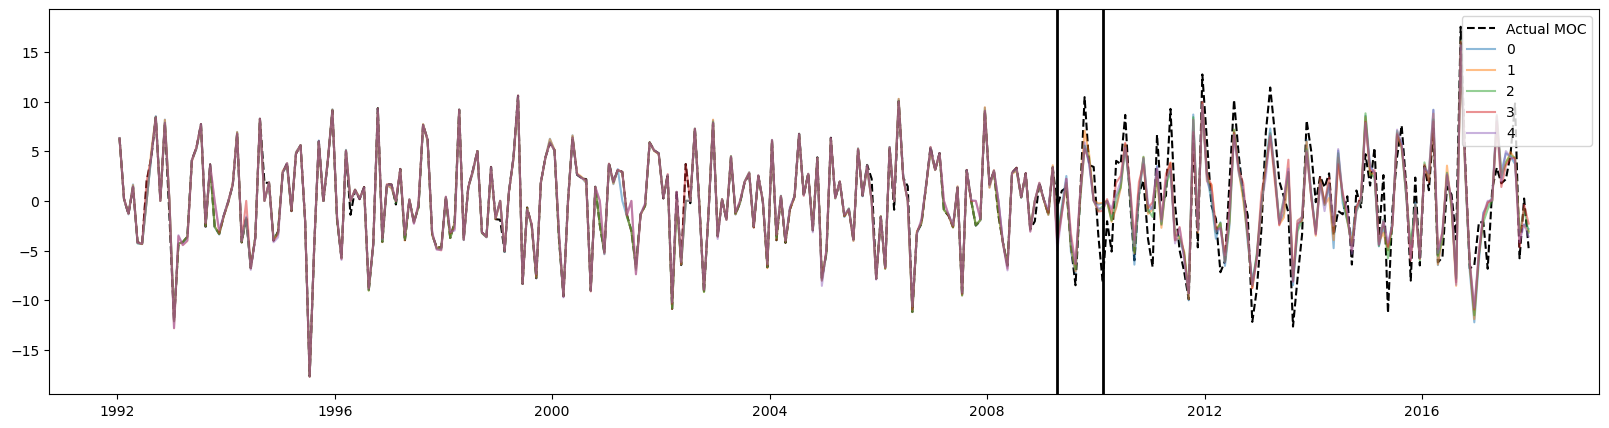

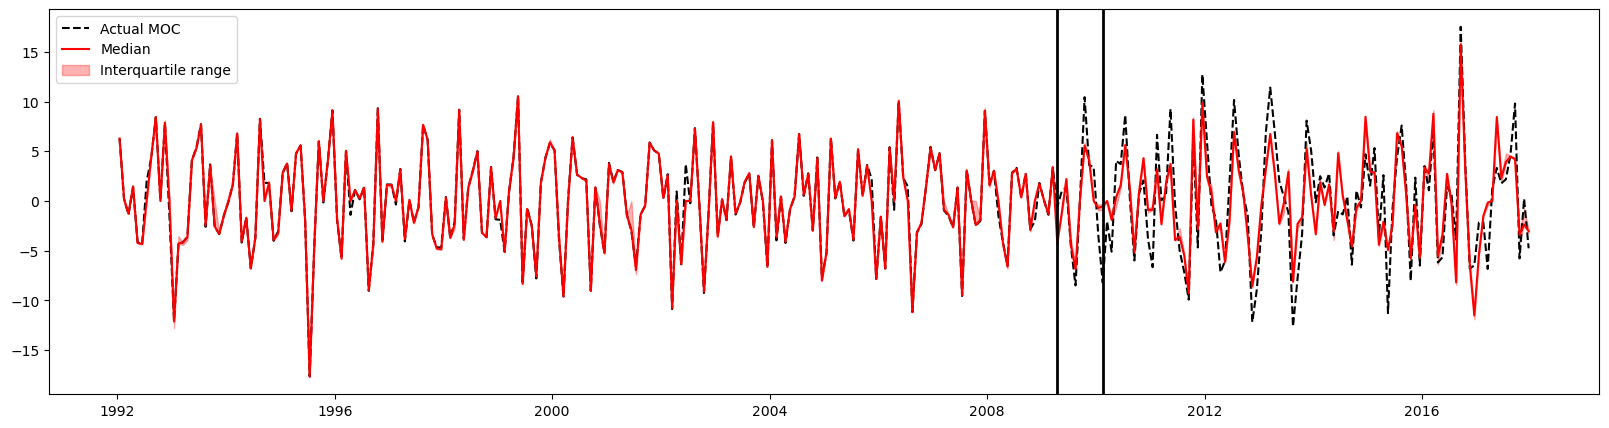

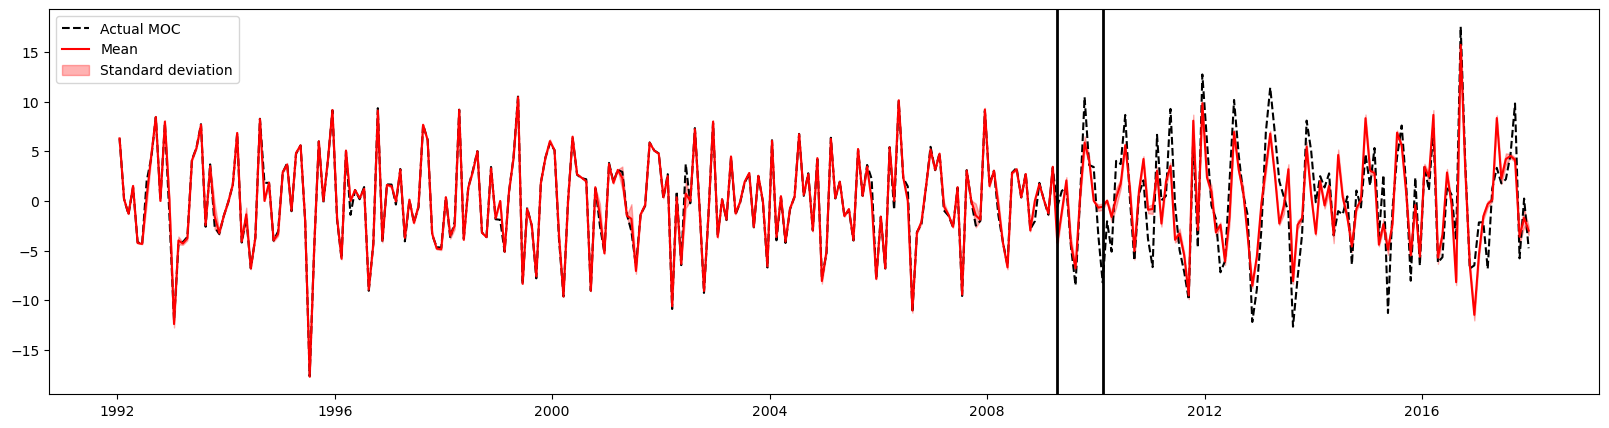

In [35]:
ens_size = 5

n_layers = 1
n_hidden = 5
dropout = 0
lr = 0.05

# for i in range(ens_size):
#     mlp = MLP(x_train_tensor.shape[1], n_layers, n_hidden, dropout)
#     train_model(mlp, x_train_tensor, y_train_tensor, f'MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP_{i}', early_stopping=True, lr=lr, X_val=x_validate_tensor, y_val=y_validate_tensor, max_iters=10000)

#     print(f'{i+1}/{ens_size} complete')

plt.figure(figsize=(20, 5))
plt.plot(x.time, y_tensor.numpy()*1e-6, label='Actual MOC', color='black', linestyle='dashed')

y_pred_arr = np.zeros((ens_size, y_tensor.shape[0]))

for i in range(ens_size):
    model = MLP(x_test_tensor.shape[1], n_layers, n_hidden, dropout)
    model.load_state_dict(torch.load(f'../ACCESS/saved_models/MLP_{n_layers}L_{n_hidden}H_drop{dropout}_lr{lr}_OBP_{i}.pt'))
    y_pred = model.forward(x_tensor).detach().numpy()
    y_pred_arr[i, :] = y_pred[:, 0]
    plt.plot(x.time, y_pred*1e-6, label=f'{i}', alpha=0.5)
print(x_train.time[-1].to_numpy())
plt.axvline(x_train.time[-1].to_numpy(), color='black', linewidth=2)
plt.axvline(x_train.time[int(len(x_train)*0.95)].to_numpy(), color='black', linewidth=2)
plt.legend()
plt.show()

y_pred_median = np.median(y_pred_arr, axis=0)
y_pred_25 = np.percentile(y_pred_arr, 25, axis=0)
y_pred_75 = np.percentile(y_pred_arr, 75, axis=0)
y_pred_mean = np.mean(y_pred_arr, axis=0)
y_pred_std = np.std(y_pred_arr, axis=0)


plt.figure(figsize=(20, 5))
plt.plot(x.time, y_tensor.numpy()*1e-6, label='Actual MOC', color='black', linestyle='dashed')
plt.plot(x.time, y_pred_median*1e-6, label='Median', color='red')
plt.fill_between(x.time, (y_pred_25)*1e-6, (y_pred_75)*1e-6, color='red', alpha=0.3, label='Interquartile range')
plt.axvline(x_train.time[-1].to_numpy(), color='black', linewidth=2)
plt.axvline(x_train.time[int(len(x_train)*0.95)].to_numpy(), color='black', linewidth=2)
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(x.time, y_tensor.numpy()*1e-6, label='Actual MOC', color='black', linestyle='dashed')
plt.plot(x.time, y_pred_mean*1e-6, label='Mean', color='red')
plt.fill_between(x.time, (y_pred_mean-y_pred_std)*1e-6, (y_pred_mean+y_pred_std)*1e-6, color='red', alpha=0.3, label='Standard deviation')
plt.axvline(x_train.time[-1].to_numpy(), color='black', linewidth=2)
plt.axvline(x_train.time[int(len(x_train)*0.95)].to_numpy(), color='black', linewidth=2)
plt.legend()
plt.show()

## Miscellaneous models used for experimentation but no final results generated.

Gaussian process regression

[[1.         0.52600878]
 [0.52600878 1.        ]]


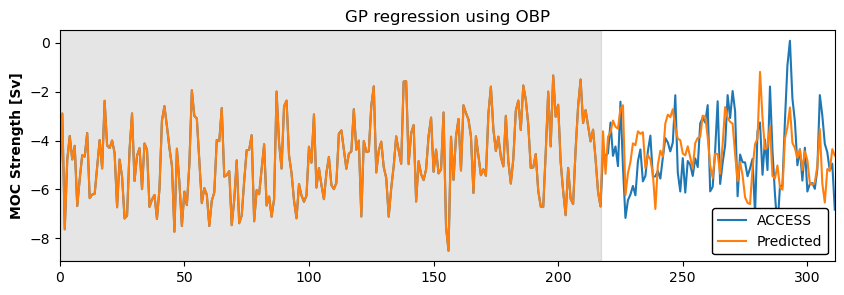

[[1.         0.52600878]
 [0.52600878 1.        ]]
1.2543584189802186
<xarray.DataArray 'MOC' ()>
array(0.9982313)
Coordinates:
    yu_ocean  float64 ...
    st_ocean  float64 ...
    sigma_2   float64 ...
<xarray.DataArray 'MOC' ()>
array(0.23410401)
Coordinates:
    yu_ocean  float64 -30.02
    st_ocean  float64 3.755e+03
    sigma_2   float64 3.755e+03


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Predicted MOC Strength [Sv]', ylabel='ACCESS MOC Strength [Sv]'>)

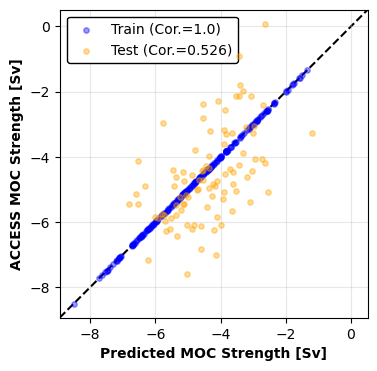

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
mape_thresh = 1*1e6


gp = GaussianProcessRegressor()
gp.fit(x_train.to_numpy(), y_train.to_numpy())
print(np.corrcoef(gp.predict(x_test.to_numpy()), y_test.to_numpy()))

# plt.plot(x_test.time, gp.predict(x_test.to_numpy())*1e-6, label='Fitted line (GP)')


timeseries_comparison(gp.predict(x)*1e-6, y*1e-6, x.time, len(x_train.time), 'ACCESS')
plt.title('GP regression using OBP')
plt.show()

print(np.corrcoef(gp.predict(x_test), y_test))
print(np.sqrt(mse(gp.predict(x_test), y_test))*1e-6)
print(np.mean(np.abs(gp.predict(x_test) - y_test))*1e-6)
print(custom_MAPE(y_test, gp.predict(x_test), threshold=mape_thresh))

pred_vs_actual(gp.predict(x_train)*1e-6, gp.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')


Echo state network

In [ ]:
from ESN import ESN
from tqdm import tqdm

mape_thresh = 0.5*1e6

n_range = np.logspace(3, 3, 1, dtype=int)
beta_range = np.linspace(10, 10, 1)


for beta in beta_range:
    
    rmse_test = []
    rmse_train = []
    cus_MAPE_test = []
    cus_MAPE_train = []
    MAPE_test = []
    MAPE_train = []

    for n in tqdm(n_range):

        

        res_model = ESN(x_train.shape[1], n, 'full', 'full', 100, beta=beta)
        res_model.fit(x_train.to_numpy(), y_train.to_numpy())

        # plt.plot(x_test.time, y_test*1e-6, label='Actual MOC')
        # plt.plot(x_test.time, res_model.predict(x_test.to_numpy())*1e-6, label='Fitted line (ESN)')

        timeseries_comparison(res_model.predict(x.to_numpy())*1e-6, y*1e-6, x.time, len(x_train.time), 'ACCESS')
        plt.show()

        # print(np.corrcoef(res_model.predict(x_test.to_numpy()), y_test))
        # print(np.sqrt(mse(res_model.predict(x_test.to_numpy()), y_test))*1e-6)
        # print(np.mean(np.abs(res_model.predict(x_test.to_numpy()) - y_test))*1e-6)

        rmse_test.append(np.sqrt(mse(res_model.predict(x_test.to_numpy()), y_test))*1e-6)
        rmse_train.append(np.sqrt(mse(res_model.predict(x_train.to_numpy()), y_train))*1e-6)

        cus_MAPE_test.append(float(custom_MAPE(y_test, res_model.predict(x_test.to_numpy()), threshold=mape_thresh, return_num_discarded=True)[0].to_numpy())*100)
        cus_MAPE_train.append(float(custom_MAPE(y_train, res_model.predict(x_train.to_numpy()), threshold=mape_thresh, return_num_discarded=True)[0].to_numpy())*100)

        MAPE_test.append(metrics.mean_absolute_percentage_error(y_test, res_model.predict(x_test.to_numpy()))*100)
        MAPE_train.append(metrics.mean_absolute_percentage_error(y_train, res_model.predict(x_train.to_numpy()))*100)

        pred_vs_actual(res_model.predict(x_train.to_numpy())*1e-6, res_model.predict(x_test.to_numpy())*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')
        plt.show()

    plt.plot(n_range, rmse_test, label='Test RMSE')
    plt.plot(n_range, rmse_train, label='Train RMSE')
    plt.legend()
    plt.xscale('log')
    plt.xlabel('Number of neurons')
    plt.ylabel('RMSE / Sv')
    plt.title(f'ESN (beta={beta})')
    plt.show()

    print(np.min(rmse_test))
    print(np.min(rmse_train))
    print(np.min(MAPE_test))
    print(np.min(MAPE_train))
    print(np.min(cus_MAPE_test))
    print(np.min(cus_MAPE_train))

In [ ]:
timeseries_comparison(res_model.predict(x.to_numpy())*1e-6, y*1e-6, x.time, len(x_train.time), 'ACCESS')

XGBoost

In [189]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', subsample=0.4, max_depth=2, n_estimators=100, learning_rate=0.1, colsample_bytree=0.1)
xg_reg.fit(x_train, y_train)

y_pred = xg_reg.predict(x_test)

timeseries_comparison(xg_reg.predict(x)*1e-6, y*1e-6, x.time, len(x_train.time), 'ACCESS')

# plt.plot(x_test.time, y_test*1e-6, label='Actual MOC')
# plt.plot(x_test.time, y_pred*1e-6, label='Fitted line (XGBoost)')
# plt.legend()

print(np.corrcoef(y_pred, y_test))
print(np.sqrt(mse(y_pred, y_test))*1e-6)
print(np.mean(np.abs(y_pred - y_test))*1e-6)
print(metrics.mean_absolute_percentage_error(y_test, y_pred)*100)

pred_vs_actual(xg_reg.predict(x_train)*1e-6, xg_reg.predict(x_test)*1e-6, y_train*1e-6, y_test*1e-6, 'ACCESS')

KeyboardInterrupt: 